## The purpose is to test the asymptotic behavior. We start with one independent variable X2, and one irrevalent variable X2

In [34]:
import numpy as np
from mip import Model, xsum, minimize, maximize, OptimizationStatus
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from numpy.linalg import inv
import time

EXP_TIMES = 1000
TIME_LEVELS = 10
SAMPLE_AMOUNT = 5000

collection = np.zeros(EXP_TIMES)

start_time = time.time()
batch = 0

for exp in range(EXP_TIMES):
    # generate
    X1 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    X2 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    X3 = np.random.uniform(-1,1,SAMPLE_AMOUNT)
    X_2and3 = np.column_stack((X2, X3))
    
    EPSI = np.random.normal(0,1,SAMPLE_AMOUNT)
    
    Y = X1 + 2 + EPSI
    
    # phi(x) = x^2
    A = 4/45
    
    # Q = 1/SAMPLE_AMOUNT * np.dot(X2,X2)  # which is a scalar
    # Q = 1/3
    Q = 1/SAMPLE_AMOUNT * np.matmul(X_2and3.T,X_2and3)
    
    
    dual_density = np.zeros((TIME_LEVELS,SAMPLE_AMOUNT))
    
    
    m = Model()
    
    pi = [[m.add_var(lb=0,name="pi") for i in range(SAMPLE_AMOUNT)] for i in range(TIME_LEVELS)]
    
    for t in range(TIME_LEVELS):
        m += xsum(pi[t][i] for i in range(SAMPLE_AMOUNT)) == SAMPLE_AMOUNT/TIME_LEVELS
        m += xsum(pi[t][i]*X1[i] for i in range(SAMPLE_AMOUNT)) == xsum(X1[i] for i in range(SAMPLE_AMOUNT))/TIME_LEVELS
        
    for i in range(SAMPLE_AMOUNT):
        m += xsum(pi[t][i] for t in range(TIME_LEVELS)) == 1
        
    m.objective = maximize(xsum(xsum(t/TIME_LEVELS * Y[i] * pi[t-1][i] for i in range(SAMPLE_AMOUNT)) for t in range(1,TIME_LEVELS+1)))
    
    status = m.optimize(max_seconds=300)
    
    if not status == OptimizationStatus.OPTIMAL:
        print("SOMETHING WRONG!")
        break

    else:
        t=0
        i=0
        for v in m.vars: 
            dual_density[t][i] = v.x
            i+=1
            if i == SAMPLE_AMOUNT:
                i=0
                t+=1
    
    # calculate target statistics
    
    b=0
    for t in range(1,TIME_LEVELS+1):
        b +=  (t/TIME_LEVELS)**2 * (dual_density[t-1])
        
        
    S = 1/np.sqrt(SAMPLE_AMOUNT) * np.matmul(X_2and3.T,b)
    
    T_STAT = np.matmul(np.matmul(S.T,inv(Q)),S)/A
    
    collection[exp] = T_STAT
    
    batch += 1
    
    if batch == 10:
        print("experiment ",exp)
        batch = 0


0.8107230566083663
11.410287823963811
3.905780584895153
8.155310250273965
0.007454399140587866
15.522684106799288
5.568645469421751
2.525935665039918
2.838684478672044
31.679635959786108
experiment  9
8.95363451781847
SOMETHING WRONG!


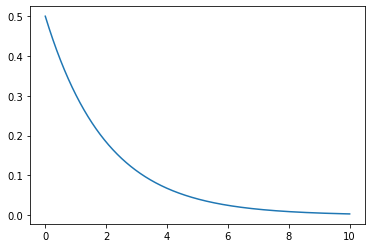

In [33]:
from scipy.stats import chi2

#x-axis ranges from 0 to 20 with .001 steps
x = np.arange(0, 10, 0.001)

#plot Chi-square distribution with 4 degrees of freedom
plt.plot(x, chi2.pdf(x, df=2))

plt.show()